# Satifsying requirements

In [1]:
import json
import torch
import pennylane as qml
import numpy as np

%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# Downloading data

In [23]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

# Preparing data with DataLoaders

In [26]:
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=80, 
                                          shuffle=True, 
                                          num_workers=1,
                                          pin_memory=True),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=80, 
                                          shuffle=True, 
                                          num_workers=1,
                                          pin_memory=True,
                                          drop_last=True),
}

# Defining a NN

In [5]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(features=inputs, wires=range(n_qubits))
    
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    return [qml.expval(qml.PauliY(wires=i)) for i in range(n_qubits)]

In [6]:
n_layers = 4
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

In [7]:
import torch.nn as nn

class HybridNN(nn.Module):
    def __init__(self):
        super(HybridNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,    
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        self.fc_1 = nn.Sequential(
            nn.Linear(32 * 7 * 7, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
        )
        
        # LIST USAGE?
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_3 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_4 = qml.qnn.TorchLayer(qnode, weight_shapes)
        
        self.qlayer_1.to(device)
        self.qlayer_2.to(device)
        self.qlayer_3.to(device)
        self.qlayer_4.to(device)
        
        self.after_q = nn.Sequential(
            nn.BatchNorm1d(16),
            nn.ReLU(),
        )
        
        self.fc_2 = nn.Linear(16, 10)

        
    def forward(self, x):

        x = self.conv1(x)

        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1) 

        x = self.fc_1(x)
        #print('Before split')
        x_1, x_2, x_3, x_4 = torch.split(x, 4, dim=1) # second argument is number of elements in one new tensor
        #print('After split')
        #x = torch.Tensor(0)
        
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x_3 = self.qlayer_3(x_3)
        x_4 = self.qlayer_4(x_4)
        
        #print(x.device)
        
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        x = x.to(device)
        x = self.after_q(x)
        logits = self.fc_2(x)
        
        return logits

In [8]:
hnn = HybridNN()
hnn = hnn.to(device)
print(hnn)

HybridNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_1): Sequential(
    (0): Linear(in_features=1568, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (qlayer_1): <Quantum Torch Layer: func=qnode>
  (qlayer_2): <Quantum Torch Layer: func=qnode>
  (qlayer_3): <Quantum Torch Layer: func=qnode>
  (qlayer_4): <Quantum Torch Layer: func=qnode>
  (after_q): Sequential(

# Training

In [9]:
loss_func = nn.CrossEntropyLoss()

In [10]:
from torch import optim

optimizer = optim.AdamW(hnn.parameters(), lr = 0.01)  

In [11]:
from tqdm.notebook import trange
from torch.autograd import Variable

def train(num_epochs, model, loaders):
    
    model.train()
    history = []
    
    avg_loss = 0.0
    val_loss = 0.0
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in trange(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            b_x, b_y = images.to(device), labels.to(device)
            
            optimizer.zero_grad()           
            
            output = model(b_x)             
            loss = loss_func(output, b_y)
            
            loss.backward()               
            optimizer.step()
            avg_loss += loss.item() / len(loaders['train'])
            
            if (i+1) % 10 >= 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
        
        model.eval()        
        for X_batch, Y_batch in loaders['test']:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            with torch.set_grad_enabled(False):
                outputs = model(X_batch)
                loss = loss_func(outputs, Y_batch)
                val_loss += loss.item() / len(loaders['test'])
            
        history.append((avg_loss, val_loss))
        print('Epoch [{}/{}], Tr. loss: {:.4f}. Test loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, avg_loss, val_loss))
        print('\n')
        torch.save(hnn.state_dict(), 'trained_model_24qubits_3_layers_with_strong_entagling_' + str(i+1) + 'ep.pt')
        with open('data_' + str(i+1) + 'ep.txt', 'w') as outfile:
            json.dump(history, outfile)
    return history

In [12]:
num_epochs = 8

history = train(num_epochs, hnn, loaders)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\OLEG\anaconda3\lib\site-packages\torch\autograd\__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:240.)
  Variable._execution_engine.run_backward(


Epoch [1/8], Step [1/750], Loss: 2.3979
Epoch [1/8], Step [2/750], Loss: 2.2228
Epoch [1/8], Step [3/750], Loss: 1.9520
Epoch [1/8], Step [4/750], Loss: 1.9574
Epoch [1/8], Step [5/750], Loss: 1.8181
Epoch [1/8], Step [6/750], Loss: 1.8627
Epoch [1/8], Step [7/750], Loss: 1.7431
Epoch [1/8], Step [8/750], Loss: 1.7685
Epoch [1/8], Step [9/750], Loss: 1.7052
Epoch [1/8], Step [10/750], Loss: 1.6744
Epoch [1/8], Step [11/750], Loss: 1.5159
Epoch [1/8], Step [12/750], Loss: 1.4878
Epoch [1/8], Step [13/750], Loss: 1.4814
Epoch [1/8], Step [14/750], Loss: 1.4064
Epoch [1/8], Step [15/750], Loss: 1.3037
Epoch [1/8], Step [16/750], Loss: 1.3518
Epoch [1/8], Step [17/750], Loss: 1.1915
Epoch [1/8], Step [18/750], Loss: 1.0946
Epoch [1/8], Step [19/750], Loss: 1.3056
Epoch [1/8], Step [20/750], Loss: 1.0981
Epoch [1/8], Step [21/750], Loss: 0.9593
Epoch [1/8], Step [22/750], Loss: 0.9579
Epoch [1/8], Step [23/750], Loss: 0.9217
Epoch [1/8], Step [24/750], Loss: 0.9114
Epoch [1/8], Step [25/750

Epoch [1/8], Step [199/750], Loss: 0.1086
Epoch [1/8], Step [200/750], Loss: 0.0826
Epoch [1/8], Step [201/750], Loss: 0.0814
Epoch [1/8], Step [202/750], Loss: 0.1621
Epoch [1/8], Step [203/750], Loss: 0.1900
Epoch [1/8], Step [204/750], Loss: 0.0765
Epoch [1/8], Step [205/750], Loss: 0.1721
Epoch [1/8], Step [206/750], Loss: 0.0381
Epoch [1/8], Step [207/750], Loss: 0.1520
Epoch [1/8], Step [208/750], Loss: 0.1146
Epoch [1/8], Step [209/750], Loss: 0.0724
Epoch [1/8], Step [210/750], Loss: 0.0965
Epoch [1/8], Step [211/750], Loss: 0.2166
Epoch [1/8], Step [212/750], Loss: 0.0263
Epoch [1/8], Step [213/750], Loss: 0.1330
Epoch [1/8], Step [214/750], Loss: 0.1819
Epoch [1/8], Step [215/750], Loss: 0.0830
Epoch [1/8], Step [216/750], Loss: 0.1117
Epoch [1/8], Step [217/750], Loss: 0.0384
Epoch [1/8], Step [218/750], Loss: 0.2119
Epoch [1/8], Step [219/750], Loss: 0.0760
Epoch [1/8], Step [220/750], Loss: 0.0402
Epoch [1/8], Step [221/750], Loss: 0.0845
Epoch [1/8], Step [222/750], Loss:

Epoch [1/8], Step [395/750], Loss: 0.1565
Epoch [1/8], Step [396/750], Loss: 0.1244
Epoch [1/8], Step [397/750], Loss: 0.0389
Epoch [1/8], Step [398/750], Loss: 0.0436
Epoch [1/8], Step [399/750], Loss: 0.0464
Epoch [1/8], Step [400/750], Loss: 0.0576
Epoch [1/8], Step [401/750], Loss: 0.0395
Epoch [1/8], Step [402/750], Loss: 0.0450
Epoch [1/8], Step [403/750], Loss: 0.0890
Epoch [1/8], Step [404/750], Loss: 0.0926
Epoch [1/8], Step [405/750], Loss: 0.0257
Epoch [1/8], Step [406/750], Loss: 0.0426
Epoch [1/8], Step [407/750], Loss: 0.0406
Epoch [1/8], Step [408/750], Loss: 0.0269
Epoch [1/8], Step [409/750], Loss: 0.1083
Epoch [1/8], Step [410/750], Loss: 0.2277
Epoch [1/8], Step [411/750], Loss: 0.0561
Epoch [1/8], Step [412/750], Loss: 0.1747
Epoch [1/8], Step [413/750], Loss: 0.1088
Epoch [1/8], Step [414/750], Loss: 0.0171
Epoch [1/8], Step [415/750], Loss: 0.1855
Epoch [1/8], Step [416/750], Loss: 0.0613
Epoch [1/8], Step [417/750], Loss: 0.0672
Epoch [1/8], Step [418/750], Loss:

Epoch [1/8], Step [591/750], Loss: 0.0336
Epoch [1/8], Step [592/750], Loss: 0.0404
Epoch [1/8], Step [593/750], Loss: 0.0649
Epoch [1/8], Step [594/750], Loss: 0.0379
Epoch [1/8], Step [595/750], Loss: 0.2648
Epoch [1/8], Step [596/750], Loss: 0.0359
Epoch [1/8], Step [597/750], Loss: 0.0971
Epoch [1/8], Step [598/750], Loss: 0.0137
Epoch [1/8], Step [599/750], Loss: 0.0607
Epoch [1/8], Step [600/750], Loss: 0.0374
Epoch [1/8], Step [601/750], Loss: 0.0231
Epoch [1/8], Step [602/750], Loss: 0.0838
Epoch [1/8], Step [603/750], Loss: 0.1036
Epoch [1/8], Step [604/750], Loss: 0.0333
Epoch [1/8], Step [605/750], Loss: 0.0904
Epoch [1/8], Step [606/750], Loss: 0.0179
Epoch [1/8], Step [607/750], Loss: 0.0402
Epoch [1/8], Step [608/750], Loss: 0.0536
Epoch [1/8], Step [609/750], Loss: 0.1216
Epoch [1/8], Step [610/750], Loss: 0.0479
Epoch [1/8], Step [611/750], Loss: 0.1219
Epoch [1/8], Step [612/750], Loss: 0.1039
Epoch [1/8], Step [613/750], Loss: 0.0473
Epoch [1/8], Step [614/750], Loss:

Epoch [2/8], Step [36/750], Loss: 0.1421
Epoch [2/8], Step [37/750], Loss: 0.1456
Epoch [2/8], Step [38/750], Loss: 0.0879
Epoch [2/8], Step [39/750], Loss: 0.0955
Epoch [2/8], Step [40/750], Loss: 0.0344
Epoch [2/8], Step [41/750], Loss: 0.0210
Epoch [2/8], Step [42/750], Loss: 0.1007
Epoch [2/8], Step [43/750], Loss: 0.0370
Epoch [2/8], Step [44/750], Loss: 0.1449
Epoch [2/8], Step [45/750], Loss: 0.2204
Epoch [2/8], Step [46/750], Loss: 0.2811
Epoch [2/8], Step [47/750], Loss: 0.0901
Epoch [2/8], Step [48/750], Loss: 0.2572
Epoch [2/8], Step [49/750], Loss: 0.1206
Epoch [2/8], Step [50/750], Loss: 0.1133
Epoch [2/8], Step [51/750], Loss: 0.0475
Epoch [2/8], Step [52/750], Loss: 0.0638
Epoch [2/8], Step [53/750], Loss: 0.0364
Epoch [2/8], Step [54/750], Loss: 0.0947
Epoch [2/8], Step [55/750], Loss: 0.0256
Epoch [2/8], Step [56/750], Loss: 0.0124
Epoch [2/8], Step [57/750], Loss: 0.1709
Epoch [2/8], Step [58/750], Loss: 0.1388
Epoch [2/8], Step [59/750], Loss: 0.0543
Epoch [2/8], Ste

Epoch [2/8], Step [233/750], Loss: 0.0263
Epoch [2/8], Step [234/750], Loss: 0.0653
Epoch [2/8], Step [235/750], Loss: 0.0434
Epoch [2/8], Step [236/750], Loss: 0.0644
Epoch [2/8], Step [237/750], Loss: 0.0369
Epoch [2/8], Step [238/750], Loss: 0.0574
Epoch [2/8], Step [239/750], Loss: 0.0256
Epoch [2/8], Step [240/750], Loss: 0.1826
Epoch [2/8], Step [241/750], Loss: 0.0393
Epoch [2/8], Step [242/750], Loss: 0.0924
Epoch [2/8], Step [243/750], Loss: 0.0999
Epoch [2/8], Step [244/750], Loss: 0.1127
Epoch [2/8], Step [245/750], Loss: 0.0322
Epoch [2/8], Step [246/750], Loss: 0.0303
Epoch [2/8], Step [247/750], Loss: 0.0034
Epoch [2/8], Step [248/750], Loss: 0.0302
Epoch [2/8], Step [249/750], Loss: 0.0450
Epoch [2/8], Step [250/750], Loss: 0.0068
Epoch [2/8], Step [251/750], Loss: 0.0208
Epoch [2/8], Step [252/750], Loss: 0.1730
Epoch [2/8], Step [253/750], Loss: 0.1017
Epoch [2/8], Step [254/750], Loss: 0.0644
Epoch [2/8], Step [255/750], Loss: 0.1254
Epoch [2/8], Step [256/750], Loss:

Epoch [2/8], Step [429/750], Loss: 0.0119
Epoch [2/8], Step [430/750], Loss: 0.0222
Epoch [2/8], Step [431/750], Loss: 0.0658
Epoch [2/8], Step [432/750], Loss: 0.0964
Epoch [2/8], Step [433/750], Loss: 0.0998
Epoch [2/8], Step [434/750], Loss: 0.2350
Epoch [2/8], Step [435/750], Loss: 0.0044
Epoch [2/8], Step [436/750], Loss: 0.0966
Epoch [2/8], Step [437/750], Loss: 0.0525
Epoch [2/8], Step [438/750], Loss: 0.0972
Epoch [2/8], Step [439/750], Loss: 0.1060
Epoch [2/8], Step [440/750], Loss: 0.0561
Epoch [2/8], Step [441/750], Loss: 0.1072
Epoch [2/8], Step [442/750], Loss: 0.1281
Epoch [2/8], Step [443/750], Loss: 0.0036
Epoch [2/8], Step [444/750], Loss: 0.1059
Epoch [2/8], Step [445/750], Loss: 0.0241
Epoch [2/8], Step [446/750], Loss: 0.1104
Epoch [2/8], Step [447/750], Loss: 0.0309
Epoch [2/8], Step [448/750], Loss: 0.1081
Epoch [2/8], Step [449/750], Loss: 0.0215
Epoch [2/8], Step [450/750], Loss: 0.1337
Epoch [2/8], Step [451/750], Loss: 0.1360
Epoch [2/8], Step [452/750], Loss:

Epoch [2/8], Step [625/750], Loss: 0.0117
Epoch [2/8], Step [626/750], Loss: 0.0126
Epoch [2/8], Step [627/750], Loss: 0.0520
Epoch [2/8], Step [628/750], Loss: 0.0069
Epoch [2/8], Step [629/750], Loss: 0.0995
Epoch [2/8], Step [630/750], Loss: 0.1095
Epoch [2/8], Step [631/750], Loss: 0.1646
Epoch [2/8], Step [632/750], Loss: 0.0273
Epoch [2/8], Step [633/750], Loss: 0.0114
Epoch [2/8], Step [634/750], Loss: 0.0364
Epoch [2/8], Step [635/750], Loss: 0.0305
Epoch [2/8], Step [636/750], Loss: 0.1275
Epoch [2/8], Step [637/750], Loss: 0.3158
Epoch [2/8], Step [638/750], Loss: 0.0179
Epoch [2/8], Step [639/750], Loss: 0.0468
Epoch [2/8], Step [640/750], Loss: 0.0453
Epoch [2/8], Step [641/750], Loss: 0.0739
Epoch [2/8], Step [642/750], Loss: 0.0988
Epoch [2/8], Step [643/750], Loss: 0.0221
Epoch [2/8], Step [644/750], Loss: 0.0729
Epoch [2/8], Step [645/750], Loss: 0.1425
Epoch [2/8], Step [646/750], Loss: 0.0422
Epoch [2/8], Step [647/750], Loss: 0.0594
Epoch [2/8], Step [648/750], Loss:

Epoch [3/8], Step [71/750], Loss: 0.0710
Epoch [3/8], Step [72/750], Loss: 0.0196
Epoch [3/8], Step [73/750], Loss: 0.0810
Epoch [3/8], Step [74/750], Loss: 0.0908
Epoch [3/8], Step [75/750], Loss: 0.0066
Epoch [3/8], Step [76/750], Loss: 0.0126
Epoch [3/8], Step [77/750], Loss: 0.0643
Epoch [3/8], Step [78/750], Loss: 0.0358
Epoch [3/8], Step [79/750], Loss: 0.0231
Epoch [3/8], Step [80/750], Loss: 0.0182
Epoch [3/8], Step [81/750], Loss: 0.0366
Epoch [3/8], Step [82/750], Loss: 0.0481
Epoch [3/8], Step [83/750], Loss: 0.0088
Epoch [3/8], Step [84/750], Loss: 0.0133
Epoch [3/8], Step [85/750], Loss: 0.0219
Epoch [3/8], Step [86/750], Loss: 0.0627
Epoch [3/8], Step [87/750], Loss: 0.0236
Epoch [3/8], Step [88/750], Loss: 0.0501
Epoch [3/8], Step [89/750], Loss: 0.0114
Epoch [3/8], Step [90/750], Loss: 0.0122
Epoch [3/8], Step [91/750], Loss: 0.0294
Epoch [3/8], Step [92/750], Loss: 0.0194
Epoch [3/8], Step [93/750], Loss: 0.1052
Epoch [3/8], Step [94/750], Loss: 0.0089
Epoch [3/8], Ste

Epoch [3/8], Step [267/750], Loss: 0.0279
Epoch [3/8], Step [268/750], Loss: 0.0520
Epoch [3/8], Step [269/750], Loss: 0.0342
Epoch [3/8], Step [270/750], Loss: 0.0103
Epoch [3/8], Step [271/750], Loss: 0.0033
Epoch [3/8], Step [272/750], Loss: 0.0555
Epoch [3/8], Step [273/750], Loss: 0.0326
Epoch [3/8], Step [274/750], Loss: 0.2048
Epoch [3/8], Step [275/750], Loss: 0.0206
Epoch [3/8], Step [276/750], Loss: 0.1554
Epoch [3/8], Step [277/750], Loss: 0.0984
Epoch [3/8], Step [278/750], Loss: 0.0115
Epoch [3/8], Step [279/750], Loss: 0.0375
Epoch [3/8], Step [280/750], Loss: 0.0298
Epoch [3/8], Step [281/750], Loss: 0.0474
Epoch [3/8], Step [282/750], Loss: 0.0849
Epoch [3/8], Step [283/750], Loss: 0.0143
Epoch [3/8], Step [284/750], Loss: 0.0501
Epoch [3/8], Step [285/750], Loss: 0.1040
Epoch [3/8], Step [286/750], Loss: 0.0633
Epoch [3/8], Step [287/750], Loss: 0.0176
Epoch [3/8], Step [288/750], Loss: 0.0101
Epoch [3/8], Step [289/750], Loss: 0.0247
Epoch [3/8], Step [290/750], Loss:

Epoch [3/8], Step [463/750], Loss: 0.0959
Epoch [3/8], Step [464/750], Loss: 0.0125
Epoch [3/8], Step [465/750], Loss: 0.0578
Epoch [3/8], Step [466/750], Loss: 0.0111
Epoch [3/8], Step [467/750], Loss: 0.0306
Epoch [3/8], Step [468/750], Loss: 0.0033
Epoch [3/8], Step [469/750], Loss: 0.0569
Epoch [3/8], Step [470/750], Loss: 0.0194
Epoch [3/8], Step [471/750], Loss: 0.0756
Epoch [3/8], Step [472/750], Loss: 0.0038
Epoch [3/8], Step [473/750], Loss: 0.0293
Epoch [3/8], Step [474/750], Loss: 0.0100
Epoch [3/8], Step [475/750], Loss: 0.0828
Epoch [3/8], Step [476/750], Loss: 0.0048
Epoch [3/8], Step [477/750], Loss: 0.0556
Epoch [3/8], Step [478/750], Loss: 0.0900
Epoch [3/8], Step [479/750], Loss: 0.0195
Epoch [3/8], Step [480/750], Loss: 0.0972
Epoch [3/8], Step [481/750], Loss: 0.0119
Epoch [3/8], Step [482/750], Loss: 0.0131
Epoch [3/8], Step [483/750], Loss: 0.0054
Epoch [3/8], Step [484/750], Loss: 0.0081
Epoch [3/8], Step [485/750], Loss: 0.1211
Epoch [3/8], Step [486/750], Loss:

Epoch [3/8], Step [659/750], Loss: 0.0153
Epoch [3/8], Step [660/750], Loss: 0.0651
Epoch [3/8], Step [661/750], Loss: 0.0065
Epoch [3/8], Step [662/750], Loss: 0.1302
Epoch [3/8], Step [663/750], Loss: 0.1240
Epoch [3/8], Step [664/750], Loss: 0.0419
Epoch [3/8], Step [665/750], Loss: 0.0116
Epoch [3/8], Step [666/750], Loss: 0.0717
Epoch [3/8], Step [667/750], Loss: 0.0042
Epoch [3/8], Step [668/750], Loss: 0.0057
Epoch [3/8], Step [669/750], Loss: 0.0150
Epoch [3/8], Step [670/750], Loss: 0.0269
Epoch [3/8], Step [671/750], Loss: 0.0489
Epoch [3/8], Step [672/750], Loss: 0.0321
Epoch [3/8], Step [673/750], Loss: 0.0081
Epoch [3/8], Step [674/750], Loss: 0.0273
Epoch [3/8], Step [675/750], Loss: 0.0521
Epoch [3/8], Step [676/750], Loss: 0.0336
Epoch [3/8], Step [677/750], Loss: 0.0458
Epoch [3/8], Step [678/750], Loss: 0.0781
Epoch [3/8], Step [679/750], Loss: 0.0598
Epoch [3/8], Step [680/750], Loss: 0.0953
Epoch [3/8], Step [681/750], Loss: 0.0930
Epoch [3/8], Step [682/750], Loss:

Epoch [4/8], Step [106/750], Loss: 0.0328
Epoch [4/8], Step [107/750], Loss: 0.0200
Epoch [4/8], Step [108/750], Loss: 0.0074
Epoch [4/8], Step [109/750], Loss: 0.0974
Epoch [4/8], Step [110/750], Loss: 0.0060
Epoch [4/8], Step [111/750], Loss: 0.0139
Epoch [4/8], Step [112/750], Loss: 0.0256
Epoch [4/8], Step [113/750], Loss: 0.1329
Epoch [4/8], Step [114/750], Loss: 0.0451
Epoch [4/8], Step [115/750], Loss: 0.0188
Epoch [4/8], Step [116/750], Loss: 0.0598
Epoch [4/8], Step [117/750], Loss: 0.0035
Epoch [4/8], Step [118/750], Loss: 0.0443
Epoch [4/8], Step [119/750], Loss: 0.0104
Epoch [4/8], Step [120/750], Loss: 0.0293
Epoch [4/8], Step [121/750], Loss: 0.0496
Epoch [4/8], Step [122/750], Loss: 0.0921
Epoch [4/8], Step [123/750], Loss: 0.0141
Epoch [4/8], Step [124/750], Loss: 0.0940
Epoch [4/8], Step [125/750], Loss: 0.0154
Epoch [4/8], Step [126/750], Loss: 0.0252
Epoch [4/8], Step [127/750], Loss: 0.0156
Epoch [4/8], Step [128/750], Loss: 0.0991
Epoch [4/8], Step [129/750], Loss:

Epoch [4/8], Step [302/750], Loss: 0.0465
Epoch [4/8], Step [303/750], Loss: 0.0450
Epoch [4/8], Step [304/750], Loss: 0.0241
Epoch [4/8], Step [305/750], Loss: 0.0162
Epoch [4/8], Step [306/750], Loss: 0.0073
Epoch [4/8], Step [307/750], Loss: 0.0340
Epoch [4/8], Step [308/750], Loss: 0.0055
Epoch [4/8], Step [309/750], Loss: 0.0744
Epoch [4/8], Step [310/750], Loss: 0.0070
Epoch [4/8], Step [311/750], Loss: 0.0166
Epoch [4/8], Step [312/750], Loss: 0.0353
Epoch [4/8], Step [313/750], Loss: 0.0109
Epoch [4/8], Step [314/750], Loss: 0.0059
Epoch [4/8], Step [315/750], Loss: 0.1054
Epoch [4/8], Step [316/750], Loss: 0.0723
Epoch [4/8], Step [317/750], Loss: 0.1668
Epoch [4/8], Step [318/750], Loss: 0.0329
Epoch [4/8], Step [319/750], Loss: 0.0195
Epoch [4/8], Step [320/750], Loss: 0.0072
Epoch [4/8], Step [321/750], Loss: 0.0220
Epoch [4/8], Step [322/750], Loss: 0.0162
Epoch [4/8], Step [323/750], Loss: 0.0539
Epoch [4/8], Step [324/750], Loss: 0.1244
Epoch [4/8], Step [325/750], Loss:

Epoch [4/8], Step [498/750], Loss: 0.0113
Epoch [4/8], Step [499/750], Loss: 0.0719
Epoch [4/8], Step [500/750], Loss: 0.1079
Epoch [4/8], Step [501/750], Loss: 0.0196
Epoch [4/8], Step [502/750], Loss: 0.0546
Epoch [4/8], Step [503/750], Loss: 0.0107
Epoch [4/8], Step [504/750], Loss: 0.0159
Epoch [4/8], Step [505/750], Loss: 0.0251
Epoch [4/8], Step [506/750], Loss: 0.0270
Epoch [4/8], Step [507/750], Loss: 0.0180
Epoch [4/8], Step [508/750], Loss: 0.0837
Epoch [4/8], Step [509/750], Loss: 0.0048
Epoch [4/8], Step [510/750], Loss: 0.0452
Epoch [4/8], Step [511/750], Loss: 0.0019
Epoch [4/8], Step [512/750], Loss: 0.0399
Epoch [4/8], Step [513/750], Loss: 0.1000
Epoch [4/8], Step [514/750], Loss: 0.0550
Epoch [4/8], Step [515/750], Loss: 0.1142
Epoch [4/8], Step [516/750], Loss: 0.0813
Epoch [4/8], Step [517/750], Loss: 0.0644
Epoch [4/8], Step [518/750], Loss: 0.0071
Epoch [4/8], Step [519/750], Loss: 0.1023
Epoch [4/8], Step [520/750], Loss: 0.0416
Epoch [4/8], Step [521/750], Loss:

Epoch [4/8], Step [694/750], Loss: 0.0104
Epoch [4/8], Step [695/750], Loss: 0.0438
Epoch [4/8], Step [696/750], Loss: 0.0837
Epoch [4/8], Step [697/750], Loss: 0.0577
Epoch [4/8], Step [698/750], Loss: 0.0718
Epoch [4/8], Step [699/750], Loss: 0.0288
Epoch [4/8], Step [700/750], Loss: 0.0144
Epoch [4/8], Step [701/750], Loss: 0.1033
Epoch [4/8], Step [702/750], Loss: 0.0210
Epoch [4/8], Step [703/750], Loss: 0.2065
Epoch [4/8], Step [704/750], Loss: 0.0616
Epoch [4/8], Step [705/750], Loss: 0.0403
Epoch [4/8], Step [706/750], Loss: 0.0660
Epoch [4/8], Step [707/750], Loss: 0.0576
Epoch [4/8], Step [708/750], Loss: 0.0050
Epoch [4/8], Step [709/750], Loss: 0.0722
Epoch [4/8], Step [710/750], Loss: 0.0275
Epoch [4/8], Step [711/750], Loss: 0.0246
Epoch [4/8], Step [712/750], Loss: 0.0146
Epoch [4/8], Step [713/750], Loss: 0.0138
Epoch [4/8], Step [714/750], Loss: 0.0417
Epoch [4/8], Step [715/750], Loss: 0.0295
Epoch [4/8], Step [716/750], Loss: 0.0668
Epoch [4/8], Step [717/750], Loss:

Epoch [5/8], Step [141/750], Loss: 0.0283
Epoch [5/8], Step [142/750], Loss: 0.0042
Epoch [5/8], Step [143/750], Loss: 0.0043
Epoch [5/8], Step [144/750], Loss: 0.0038
Epoch [5/8], Step [145/750], Loss: 0.1277
Epoch [5/8], Step [146/750], Loss: 0.0125
Epoch [5/8], Step [147/750], Loss: 0.0010
Epoch [5/8], Step [148/750], Loss: 0.0219
Epoch [5/8], Step [149/750], Loss: 0.0177
Epoch [5/8], Step [150/750], Loss: 0.0350
Epoch [5/8], Step [151/750], Loss: 0.0082
Epoch [5/8], Step [152/750], Loss: 0.0201
Epoch [5/8], Step [153/750], Loss: 0.0401
Epoch [5/8], Step [154/750], Loss: 0.0050
Epoch [5/8], Step [155/750], Loss: 0.0230
Epoch [5/8], Step [156/750], Loss: 0.0092
Epoch [5/8], Step [157/750], Loss: 0.0015
Epoch [5/8], Step [158/750], Loss: 0.0041
Epoch [5/8], Step [159/750], Loss: 0.0075
Epoch [5/8], Step [160/750], Loss: 0.0250
Epoch [5/8], Step [161/750], Loss: 0.0326
Epoch [5/8], Step [162/750], Loss: 0.0597
Epoch [5/8], Step [163/750], Loss: 0.0801
Epoch [5/8], Step [164/750], Loss:

Epoch [5/8], Step [337/750], Loss: 0.0024
Epoch [5/8], Step [338/750], Loss: 0.0402
Epoch [5/8], Step [339/750], Loss: 0.0033
Epoch [5/8], Step [340/750], Loss: 0.0655
Epoch [5/8], Step [341/750], Loss: 0.0132
Epoch [5/8], Step [342/750], Loss: 0.0854
Epoch [5/8], Step [343/750], Loss: 0.0073
Epoch [5/8], Step [344/750], Loss: 0.0079
Epoch [5/8], Step [345/750], Loss: 0.0523
Epoch [5/8], Step [346/750], Loss: 0.0022
Epoch [5/8], Step [347/750], Loss: 0.0030
Epoch [5/8], Step [348/750], Loss: 0.0602
Epoch [5/8], Step [349/750], Loss: 0.0027
Epoch [5/8], Step [350/750], Loss: 0.0101
Epoch [5/8], Step [351/750], Loss: 0.0167
Epoch [5/8], Step [352/750], Loss: 0.0282
Epoch [5/8], Step [353/750], Loss: 0.0105
Epoch [5/8], Step [354/750], Loss: 0.0312
Epoch [5/8], Step [355/750], Loss: 0.0299
Epoch [5/8], Step [356/750], Loss: 0.0124
Epoch [5/8], Step [357/750], Loss: 0.2331
Epoch [5/8], Step [358/750], Loss: 0.0146
Epoch [5/8], Step [359/750], Loss: 0.0200
Epoch [5/8], Step [360/750], Loss:

Epoch [5/8], Step [533/750], Loss: 0.0453
Epoch [5/8], Step [534/750], Loss: 0.0113
Epoch [5/8], Step [535/750], Loss: 0.0343
Epoch [5/8], Step [536/750], Loss: 0.0346
Epoch [5/8], Step [537/750], Loss: 0.0093
Epoch [5/8], Step [538/750], Loss: 0.0082
Epoch [5/8], Step [539/750], Loss: 0.0326
Epoch [5/8], Step [540/750], Loss: 0.0114
Epoch [5/8], Step [541/750], Loss: 0.0348
Epoch [5/8], Step [542/750], Loss: 0.0952
Epoch [5/8], Step [543/750], Loss: 0.0030
Epoch [5/8], Step [544/750], Loss: 0.0276
Epoch [5/8], Step [545/750], Loss: 0.0284
Epoch [5/8], Step [546/750], Loss: 0.0824
Epoch [5/8], Step [547/750], Loss: 0.0211
Epoch [5/8], Step [548/750], Loss: 0.1553
Epoch [5/8], Step [549/750], Loss: 0.0051
Epoch [5/8], Step [550/750], Loss: 0.0034
Epoch [5/8], Step [551/750], Loss: 0.0045
Epoch [5/8], Step [552/750], Loss: 0.0047
Epoch [5/8], Step [553/750], Loss: 0.0098
Epoch [5/8], Step [554/750], Loss: 0.0126
Epoch [5/8], Step [555/750], Loss: 0.0767
Epoch [5/8], Step [556/750], Loss:

Epoch [5/8], Step [729/750], Loss: 0.0136
Epoch [5/8], Step [730/750], Loss: 0.0110
Epoch [5/8], Step [731/750], Loss: 0.0766
Epoch [5/8], Step [732/750], Loss: 0.0725
Epoch [5/8], Step [733/750], Loss: 0.0124
Epoch [5/8], Step [734/750], Loss: 0.0175
Epoch [5/8], Step [735/750], Loss: 0.0883
Epoch [5/8], Step [736/750], Loss: 0.0337
Epoch [5/8], Step [737/750], Loss: 0.0382
Epoch [5/8], Step [738/750], Loss: 0.0108
Epoch [5/8], Step [739/750], Loss: 0.0128
Epoch [5/8], Step [740/750], Loss: 0.0115
Epoch [5/8], Step [741/750], Loss: 0.0037
Epoch [5/8], Step [742/750], Loss: 0.0252
Epoch [5/8], Step [743/750], Loss: 0.0251
Epoch [5/8], Step [744/750], Loss: 0.0271
Epoch [5/8], Step [745/750], Loss: 0.0046
Epoch [5/8], Step [746/750], Loss: 0.0096
Epoch [5/8], Step [747/750], Loss: 0.0725
Epoch [5/8], Step [748/750], Loss: 0.0829
Epoch [5/8], Step [749/750], Loss: 0.0734
Epoch [5/8], Step [750/750], Loss: 0.0252
Epoch [5/8], Tr. loss: 0.3392. Test loss: 0.2205


Epoch [6/8], Step [1/750]

Epoch [6/8], Step [176/750], Loss: 0.1190
Epoch [6/8], Step [177/750], Loss: 0.0291
Epoch [6/8], Step [178/750], Loss: 0.0299
Epoch [6/8], Step [179/750], Loss: 0.0023
Epoch [6/8], Step [180/750], Loss: 0.0044
Epoch [6/8], Step [181/750], Loss: 0.0218
Epoch [6/8], Step [182/750], Loss: 0.0261
Epoch [6/8], Step [183/750], Loss: 0.0164
Epoch [6/8], Step [184/750], Loss: 0.0228
Epoch [6/8], Step [185/750], Loss: 0.0926
Epoch [6/8], Step [186/750], Loss: 0.0624
Epoch [6/8], Step [187/750], Loss: 0.0152
Epoch [6/8], Step [188/750], Loss: 0.0187
Epoch [6/8], Step [189/750], Loss: 0.0041
Epoch [6/8], Step [190/750], Loss: 0.0057
Epoch [6/8], Step [191/750], Loss: 0.0117
Epoch [6/8], Step [192/750], Loss: 0.0175
Epoch [6/8], Step [193/750], Loss: 0.0203
Epoch [6/8], Step [194/750], Loss: 0.0040
Epoch [6/8], Step [195/750], Loss: 0.0089
Epoch [6/8], Step [196/750], Loss: 0.0025
Epoch [6/8], Step [197/750], Loss: 0.0351
Epoch [6/8], Step [198/750], Loss: 0.0045
Epoch [6/8], Step [199/750], Loss:

Epoch [6/8], Step [372/750], Loss: 0.0069
Epoch [6/8], Step [373/750], Loss: 0.0055
Epoch [6/8], Step [374/750], Loss: 0.0061
Epoch [6/8], Step [375/750], Loss: 0.0292
Epoch [6/8], Step [376/750], Loss: 0.0218
Epoch [6/8], Step [377/750], Loss: 0.0437
Epoch [6/8], Step [378/750], Loss: 0.0207
Epoch [6/8], Step [379/750], Loss: 0.0098
Epoch [6/8], Step [380/750], Loss: 0.0726
Epoch [6/8], Step [381/750], Loss: 0.0170
Epoch [6/8], Step [382/750], Loss: 0.0022
Epoch [6/8], Step [383/750], Loss: 0.0311
Epoch [6/8], Step [384/750], Loss: 0.0217
Epoch [6/8], Step [385/750], Loss: 0.0410
Epoch [6/8], Step [386/750], Loss: 0.0078
Epoch [6/8], Step [387/750], Loss: 0.0865
Epoch [6/8], Step [388/750], Loss: 0.0564
Epoch [6/8], Step [389/750], Loss: 0.0516
Epoch [6/8], Step [390/750], Loss: 0.0120
Epoch [6/8], Step [391/750], Loss: 0.0241
Epoch [6/8], Step [392/750], Loss: 0.0116
Epoch [6/8], Step [393/750], Loss: 0.0060
Epoch [6/8], Step [394/750], Loss: 0.0061
Epoch [6/8], Step [395/750], Loss:

Epoch [6/8], Step [568/750], Loss: 0.0030
Epoch [6/8], Step [569/750], Loss: 0.0580
Epoch [6/8], Step [570/750], Loss: 0.0081
Epoch [6/8], Step [571/750], Loss: 0.0410
Epoch [6/8], Step [572/750], Loss: 0.0204
Epoch [6/8], Step [573/750], Loss: 0.0017
Epoch [6/8], Step [574/750], Loss: 0.0025
Epoch [6/8], Step [575/750], Loss: 0.0124
Epoch [6/8], Step [576/750], Loss: 0.0105
Epoch [6/8], Step [577/750], Loss: 0.0094
Epoch [6/8], Step [578/750], Loss: 0.0898
Epoch [6/8], Step [579/750], Loss: 0.0814
Epoch [6/8], Step [580/750], Loss: 0.0527
Epoch [6/8], Step [581/750], Loss: 0.0056
Epoch [6/8], Step [582/750], Loss: 0.0139
Epoch [6/8], Step [583/750], Loss: 0.0047
Epoch [6/8], Step [584/750], Loss: 0.0061
Epoch [6/8], Step [585/750], Loss: 0.0770
Epoch [6/8], Step [586/750], Loss: 0.0806
Epoch [6/8], Step [587/750], Loss: 0.0982
Epoch [6/8], Step [588/750], Loss: 0.0046
Epoch [6/8], Step [589/750], Loss: 0.0058
Epoch [6/8], Step [590/750], Loss: 0.0101
Epoch [6/8], Step [591/750], Loss:

Epoch [7/8], Step [13/750], Loss: 0.0110
Epoch [7/8], Step [14/750], Loss: 0.0012
Epoch [7/8], Step [15/750], Loss: 0.0056
Epoch [7/8], Step [16/750], Loss: 0.0349
Epoch [7/8], Step [17/750], Loss: 0.0022
Epoch [7/8], Step [18/750], Loss: 0.0022
Epoch [7/8], Step [19/750], Loss: 0.0013
Epoch [7/8], Step [20/750], Loss: 0.0038
Epoch [7/8], Step [21/750], Loss: 0.0067
Epoch [7/8], Step [22/750], Loss: 0.0641
Epoch [7/8], Step [23/750], Loss: 0.0016
Epoch [7/8], Step [24/750], Loss: 0.0069
Epoch [7/8], Step [25/750], Loss: 0.0018
Epoch [7/8], Step [26/750], Loss: 0.0186
Epoch [7/8], Step [27/750], Loss: 0.0037
Epoch [7/8], Step [28/750], Loss: 0.0014
Epoch [7/8], Step [29/750], Loss: 0.0041
Epoch [7/8], Step [30/750], Loss: 0.0182
Epoch [7/8], Step [31/750], Loss: 0.0239
Epoch [7/8], Step [32/750], Loss: 0.0022
Epoch [7/8], Step [33/750], Loss: 0.0038
Epoch [7/8], Step [34/750], Loss: 0.0100
Epoch [7/8], Step [35/750], Loss: 0.0065
Epoch [7/8], Step [36/750], Loss: 0.0087
Epoch [7/8], Ste

Epoch [7/8], Step [211/750], Loss: 0.0387
Epoch [7/8], Step [212/750], Loss: 0.0205
Epoch [7/8], Step [213/750], Loss: 0.0361
Epoch [7/8], Step [214/750], Loss: 0.0018
Epoch [7/8], Step [215/750], Loss: 0.0691
Epoch [7/8], Step [216/750], Loss: 0.0091
Epoch [7/8], Step [217/750], Loss: 0.0562
Epoch [7/8], Step [218/750], Loss: 0.0011
Epoch [7/8], Step [219/750], Loss: 0.0330
Epoch [7/8], Step [220/750], Loss: 0.0020
Epoch [7/8], Step [221/750], Loss: 0.0066
Epoch [7/8], Step [222/750], Loss: 0.0023
Epoch [7/8], Step [223/750], Loss: 0.0076
Epoch [7/8], Step [224/750], Loss: 0.0316
Epoch [7/8], Step [225/750], Loss: 0.0282
Epoch [7/8], Step [226/750], Loss: 0.0294
Epoch [7/8], Step [227/750], Loss: 0.0118
Epoch [7/8], Step [228/750], Loss: 0.0195
Epoch [7/8], Step [229/750], Loss: 0.0054
Epoch [7/8], Step [230/750], Loss: 0.0541
Epoch [7/8], Step [231/750], Loss: 0.0545
Epoch [7/8], Step [232/750], Loss: 0.0429
Epoch [7/8], Step [233/750], Loss: 0.0065
Epoch [7/8], Step [234/750], Loss:

Epoch [7/8], Step [407/750], Loss: 0.0103
Epoch [7/8], Step [408/750], Loss: 0.0169
Epoch [7/8], Step [409/750], Loss: 0.0258
Epoch [7/8], Step [410/750], Loss: 0.0683
Epoch [7/8], Step [411/750], Loss: 0.0367
Epoch [7/8], Step [412/750], Loss: 0.0157
Epoch [7/8], Step [413/750], Loss: 0.0511
Epoch [7/8], Step [414/750], Loss: 0.0166
Epoch [7/8], Step [415/750], Loss: 0.0106
Epoch [7/8], Step [416/750], Loss: 0.0920
Epoch [7/8], Step [417/750], Loss: 0.0038
Epoch [7/8], Step [418/750], Loss: 0.0307
Epoch [7/8], Step [419/750], Loss: 0.0399
Epoch [7/8], Step [420/750], Loss: 0.0045
Epoch [7/8], Step [421/750], Loss: 0.0048
Epoch [7/8], Step [422/750], Loss: 0.0097
Epoch [7/8], Step [423/750], Loss: 0.0094
Epoch [7/8], Step [424/750], Loss: 0.1687
Epoch [7/8], Step [425/750], Loss: 0.0132
Epoch [7/8], Step [426/750], Loss: 0.0086
Epoch [7/8], Step [427/750], Loss: 0.0607
Epoch [7/8], Step [428/750], Loss: 0.0313
Epoch [7/8], Step [429/750], Loss: 0.0506
Epoch [7/8], Step [430/750], Loss:

Epoch [7/8], Step [603/750], Loss: 0.0095
Epoch [7/8], Step [604/750], Loss: 0.0149
Epoch [7/8], Step [605/750], Loss: 0.0026
Epoch [7/8], Step [606/750], Loss: 0.0259
Epoch [7/8], Step [607/750], Loss: 0.0362
Epoch [7/8], Step [608/750], Loss: 0.0091
Epoch [7/8], Step [609/750], Loss: 0.0736
Epoch [7/8], Step [610/750], Loss: 0.0174
Epoch [7/8], Step [611/750], Loss: 0.0245
Epoch [7/8], Step [612/750], Loss: 0.1610
Epoch [7/8], Step [613/750], Loss: 0.0138
Epoch [7/8], Step [614/750], Loss: 0.0143
Epoch [7/8], Step [615/750], Loss: 0.0510
Epoch [7/8], Step [616/750], Loss: 0.0175
Epoch [7/8], Step [617/750], Loss: 0.0638
Epoch [7/8], Step [618/750], Loss: 0.0030
Epoch [7/8], Step [619/750], Loss: 0.0040
Epoch [7/8], Step [620/750], Loss: 0.0293
Epoch [7/8], Step [621/750], Loss: 0.0046
Epoch [7/8], Step [622/750], Loss: 0.0255
Epoch [7/8], Step [623/750], Loss: 0.0059
Epoch [7/8], Step [624/750], Loss: 0.0262
Epoch [7/8], Step [625/750], Loss: 0.0034
Epoch [7/8], Step [626/750], Loss:

Epoch [8/8], Step [49/750], Loss: 0.0056
Epoch [8/8], Step [50/750], Loss: 0.0735
Epoch [8/8], Step [51/750], Loss: 0.0473
Epoch [8/8], Step [52/750], Loss: 0.0226
Epoch [8/8], Step [53/750], Loss: 0.0190
Epoch [8/8], Step [54/750], Loss: 0.0111
Epoch [8/8], Step [55/750], Loss: 0.0602
Epoch [8/8], Step [56/750], Loss: 0.0020
Epoch [8/8], Step [57/750], Loss: 0.0328
Epoch [8/8], Step [58/750], Loss: 0.0053
Epoch [8/8], Step [59/750], Loss: 0.0058
Epoch [8/8], Step [60/750], Loss: 0.0015
Epoch [8/8], Step [61/750], Loss: 0.0310
Epoch [8/8], Step [62/750], Loss: 0.0043
Epoch [8/8], Step [63/750], Loss: 0.0023
Epoch [8/8], Step [64/750], Loss: 0.0583
Epoch [8/8], Step [65/750], Loss: 0.0522
Epoch [8/8], Step [66/750], Loss: 0.0720
Epoch [8/8], Step [67/750], Loss: 0.0101
Epoch [8/8], Step [68/750], Loss: 0.0036
Epoch [8/8], Step [69/750], Loss: 0.0583
Epoch [8/8], Step [70/750], Loss: 0.0146
Epoch [8/8], Step [71/750], Loss: 0.0019
Epoch [8/8], Step [72/750], Loss: 0.0172
Epoch [8/8], Ste

Epoch [8/8], Step [246/750], Loss: 0.0094
Epoch [8/8], Step [247/750], Loss: 0.0100
Epoch [8/8], Step [248/750], Loss: 0.0073
Epoch [8/8], Step [249/750], Loss: 0.0234
Epoch [8/8], Step [250/750], Loss: 0.0257
Epoch [8/8], Step [251/750], Loss: 0.0241
Epoch [8/8], Step [252/750], Loss: 0.0195
Epoch [8/8], Step [253/750], Loss: 0.0932
Epoch [8/8], Step [254/750], Loss: 0.0096
Epoch [8/8], Step [255/750], Loss: 0.0366
Epoch [8/8], Step [256/750], Loss: 0.0048
Epoch [8/8], Step [257/750], Loss: 0.0062
Epoch [8/8], Step [258/750], Loss: 0.0182
Epoch [8/8], Step [259/750], Loss: 0.0142
Epoch [8/8], Step [260/750], Loss: 0.0203
Epoch [8/8], Step [261/750], Loss: 0.0063
Epoch [8/8], Step [262/750], Loss: 0.0452
Epoch [8/8], Step [263/750], Loss: 0.0475
Epoch [8/8], Step [264/750], Loss: 0.0063
Epoch [8/8], Step [265/750], Loss: 0.0053
Epoch [8/8], Step [266/750], Loss: 0.0027
Epoch [8/8], Step [267/750], Loss: 0.0081
Epoch [8/8], Step [268/750], Loss: 0.0028
Epoch [8/8], Step [269/750], Loss:

Epoch [8/8], Step [442/750], Loss: 0.0015
Epoch [8/8], Step [443/750], Loss: 0.0173
Epoch [8/8], Step [444/750], Loss: 0.0022
Epoch [8/8], Step [445/750], Loss: 0.0218
Epoch [8/8], Step [446/750], Loss: 0.0527
Epoch [8/8], Step [447/750], Loss: 0.0218
Epoch [8/8], Step [448/750], Loss: 0.0156
Epoch [8/8], Step [449/750], Loss: 0.1149
Epoch [8/8], Step [450/750], Loss: 0.0361
Epoch [8/8], Step [451/750], Loss: 0.0086
Epoch [8/8], Step [452/750], Loss: 0.0267
Epoch [8/8], Step [453/750], Loss: 0.0287
Epoch [8/8], Step [454/750], Loss: 0.0272
Epoch [8/8], Step [455/750], Loss: 0.0013
Epoch [8/8], Step [456/750], Loss: 0.0105
Epoch [8/8], Step [457/750], Loss: 0.0222
Epoch [8/8], Step [458/750], Loss: 0.1350
Epoch [8/8], Step [459/750], Loss: 0.0167
Epoch [8/8], Step [460/750], Loss: 0.0824
Epoch [8/8], Step [461/750], Loss: 0.0028
Epoch [8/8], Step [462/750], Loss: 0.0600
Epoch [8/8], Step [463/750], Loss: 0.0013
Epoch [8/8], Step [464/750], Loss: 0.0194
Epoch [8/8], Step [465/750], Loss:

Epoch [8/8], Step [638/750], Loss: 0.0029
Epoch [8/8], Step [639/750], Loss: 0.0126
Epoch [8/8], Step [640/750], Loss: 0.0029
Epoch [8/8], Step [641/750], Loss: 0.0133
Epoch [8/8], Step [642/750], Loss: 0.0029
Epoch [8/8], Step [643/750], Loss: 0.0461
Epoch [8/8], Step [644/750], Loss: 0.0024
Epoch [8/8], Step [645/750], Loss: 0.0074
Epoch [8/8], Step [646/750], Loss: 0.0135
Epoch [8/8], Step [647/750], Loss: 0.0157
Epoch [8/8], Step [648/750], Loss: 0.0144
Epoch [8/8], Step [649/750], Loss: 0.0538
Epoch [8/8], Step [650/750], Loss: 0.0014
Epoch [8/8], Step [651/750], Loss: 0.0119
Epoch [8/8], Step [652/750], Loss: 0.0650
Epoch [8/8], Step [653/750], Loss: 0.0052
Epoch [8/8], Step [654/750], Loss: 0.0039
Epoch [8/8], Step [655/750], Loss: 0.0025
Epoch [8/8], Step [656/750], Loss: 0.0587
Epoch [8/8], Step [657/750], Loss: 0.0712
Epoch [8/8], Step [658/750], Loss: 0.0278
Epoch [8/8], Step [659/750], Loss: 0.1219
Epoch [8/8], Step [660/750], Loss: 0.0391
Epoch [8/8], Step [661/750], Loss:

In [13]:
torch.save(hnn.state_dict(), 'trained_model_24qubits_3_layers_with_strong_entagling.pt')

In [14]:
with open('data.txt', 'w') as outfile:
    json.dump(history, outfile)

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.4)

def draw_plot(history):
    loss, val_loss = zip(*history)
    losses = []
    val_losses = []
    for i in range(len(loss)):
        losses.append(loss[i])
        val_losses.append(val_loss[i])
        for j in range(i):
            losses[i] -= losses[j]
            val_losses[i] -= val_losses[j]
            
    plt.figure(figsize=(15, 9))
    plt.plot(losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

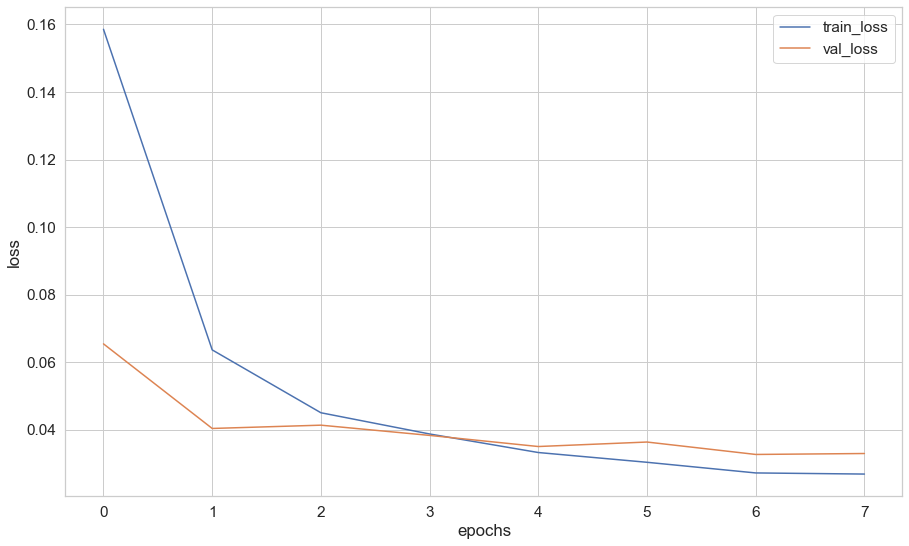

In [35]:
draw_plot(history)

In [31]:
def test(model):
    # Test the model
    model.eval()
    with torch.no_grad():
        accuracy = 0
        for i, (images, labels) in enumerate(loaders['test']):
            print(i)
            images, labels = images.to(device), labels.to(device)
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1]
            accuracy += (pred_y == labels).sum().item() 
        accuracy /= len(loaders['test'].dataset)
        print('Test Accuracy of the model on the 10000 test images: {:.2f} %'.format(accuracy*100.0))

In [32]:
test(hnn)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
Test Accuracy of the model on the 10000 test images: 99.02 %
